### Problem Statement
Predicting Survival in the Titanic Data Set with only Pclass, Sex, Age, SibSp (Siblings aboard), Parch(Parents/children aboard), and Fare.
We will be using a decision tree to make predictions about the Titanic data
set from Kaggle. 

### Dataset
This data set provides information on the Titanic
passengers and can be used to predict whether a passenger survived or
not.

### Description of Variables
1. Survived: Survival (0 = No; 1 = Yes)
2. Pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
3. Name: Name of the Passenger
4. Sex: Sex of the Passenger
5. Age: Age of the Passenger
6. Sibsp: Number of Siblings/Spouses Aboard
7. Parch: Number of Parents/Children Aboard
8. Ticket: Ticket Number
9. Fare: Passenger Fare (British pound)
10. Cabin: Cabin of the Passenger
11. Embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [1]:
#Loading Data and modules
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import seaborn as sns
import pydotplus
from IPython.display import Image 

url="https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"
titanic = pd.read_csv(url)
titanic.columns =['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

In [2]:
# first 5 rows of the dataset
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# checking dtype
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# checking data description
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Here we notice some null values in the age column. Let's fix it.

In [5]:
# pulling salutation from name
titanic['Salutation'] = titanic["Name"].apply(lambda name: name.split(',')[1].split('.')[0].strip())

# filling nan values by taking the median of age grouped on the basis salutation, sex and passenger class
titanic["Age"] = titanic.groupby(['Salutation','Sex','Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

We no longer have any null values. Let's remove the columns we do not need and convert the Sex column from categorical features to numerical values. 

In [6]:
# dropping unecessary columns
titanic.drop(['PassengerId','Name','Ticket','Cabin','Embarked','Salutation'], axis=1,inplace=True)

# label encoding
titanic['Sex'].replace(['female','male'],[0,1], inplace=True)

Let us plot the correlation matrix.

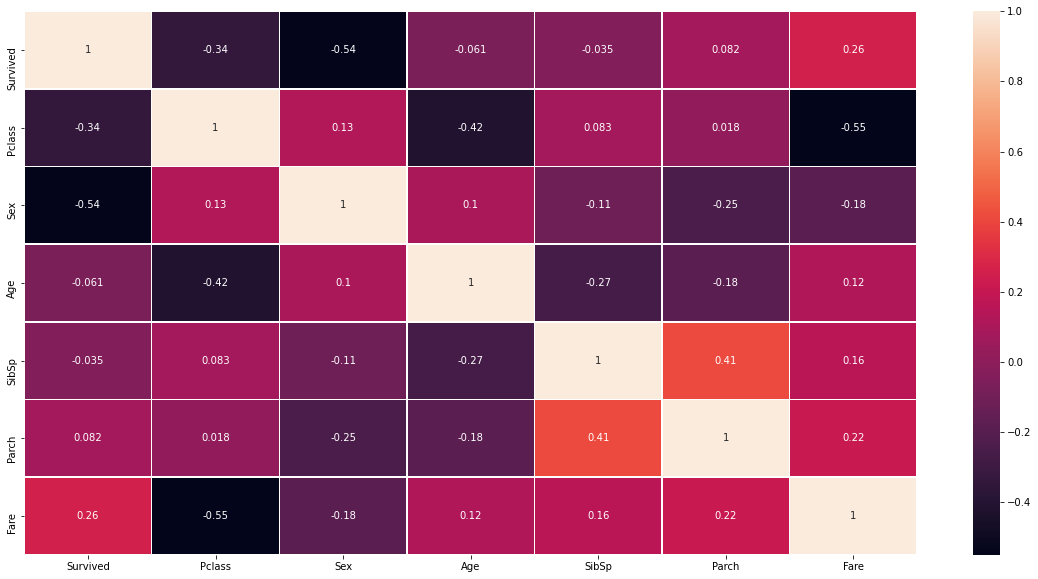

In [7]:
# creation and plotting of corrMatrix
corrMatrix = titanic.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrMatrix, annot=True,  linewidths=.5, ax=ax)
plt.show()

There is no significant corelation between the predictors. Let us check for multicolinearity.

In [8]:
# calculation of variance inflation factor
vif_data = pd.DataFrame() 
vif_data["feature"] = titanic.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(titanic.values, i) 
                          for i in range(len(titanic.columns))] 
  
print(vif_data)

    feature       VIF
0  Survived  1.940336
1    Pclass  4.871338
2       Sex  3.687377
3       Age  4.278092
4     SibSp  1.579467
5     Parch  1.601275
6      Fare  1.893374


Since vif for our features are below 5 we can use them in our model. Let's start preparing our data for model training.

In [9]:
# creation of x features and y labels
X = titanic.drop(["Survived"], axis=1)
y = titanic["Survived"]

In [10]:
# creation of train test split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size= 0.25, random_state = 355)

In [11]:
#let's first visualize the tree on the data without doing any pre processing
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)

DecisionTreeClassifier()

In [12]:
feature_name=list(X.columns)
class_name = list(y_train.unique())
feature_name

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

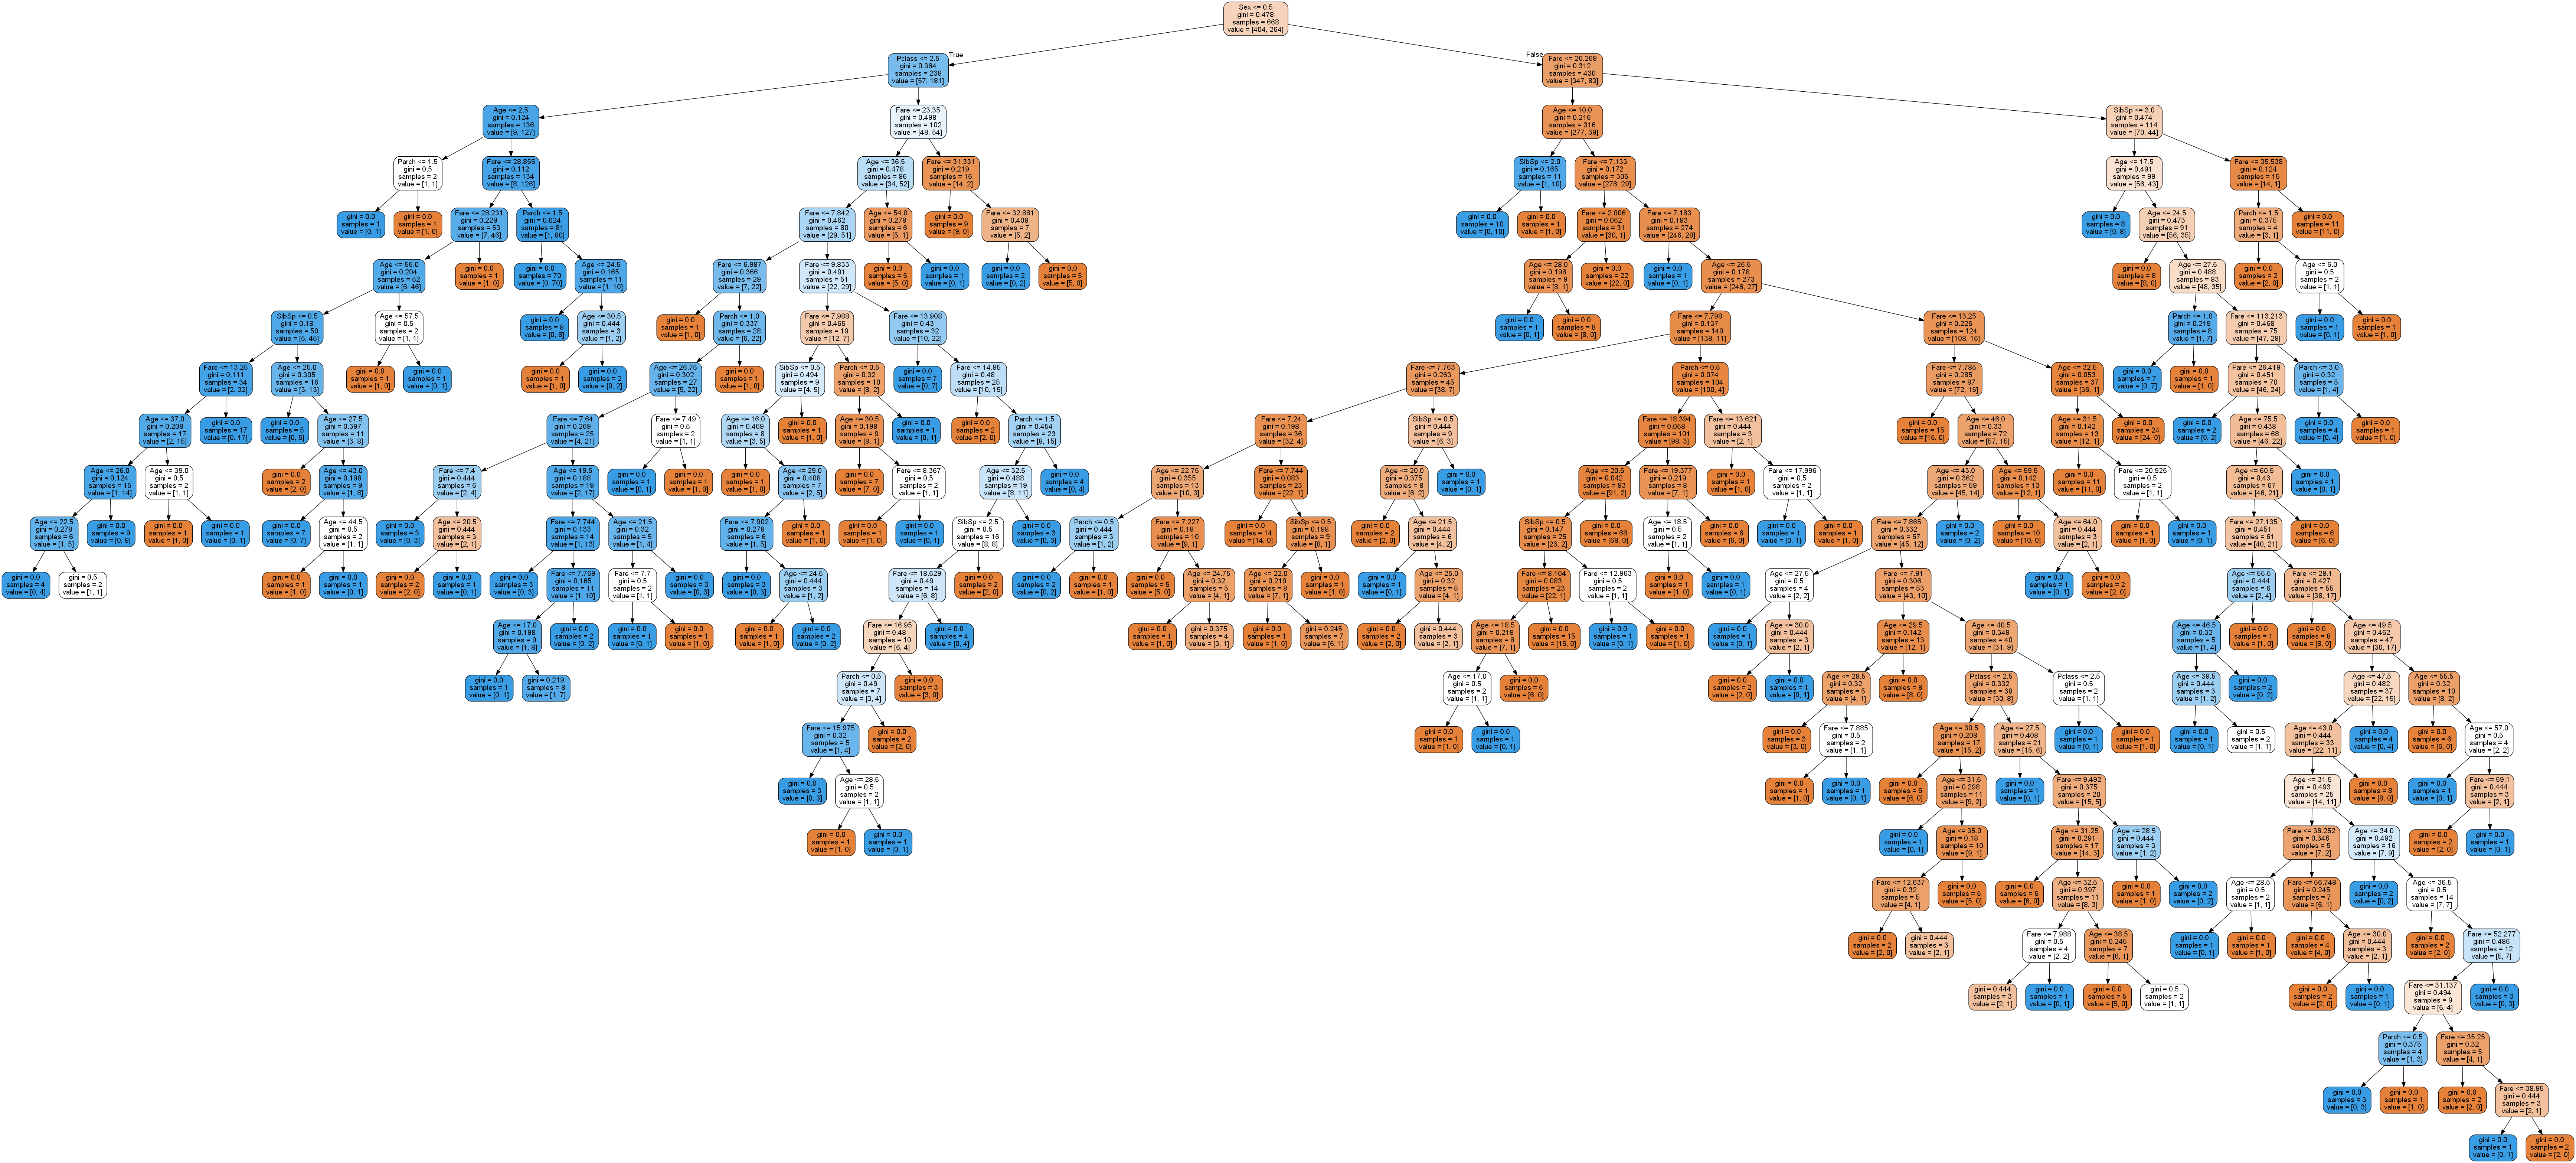

In [13]:
# create a dot_file which stores the tree structure
dot_data = export_graphviz(clf,feature_names = feature_name,rounded = True,filled = True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png("myTree.png")
# Show graph
Image(graph.create_png())

In [14]:
# train accuracy
clf.score(x_train,y_train)

0.9865269461077845

In [15]:
# accuracy of our classification tree
clf.score(x_test,y_test)

0.7443946188340808

Let's perform hyperparameters tuning.

In [16]:
# we are tuning hyperparameters right now, we are passing the different values for each parameter
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,32,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random']
    
}

In [17]:
grid_search = GridSearchCV(estimator=clf,
                     param_grid=grid_param,
                     cv=5,
                    n_jobs =-1)

In [18]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 32),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']})

In [19]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'random'}


In [20]:
grid_search.best_score_

0.8307821793289193

We shall use the best parameters for training our data.

In [24]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth =7, min_samples_leaf= 2, min_samples_split= 7, splitter ='random')
clf.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2,
                       min_samples_split=7, splitter='random')

In [25]:
clf.score(x_test,y_test)

0.8026905829596412

Our test score has considerably improved after using grid search.

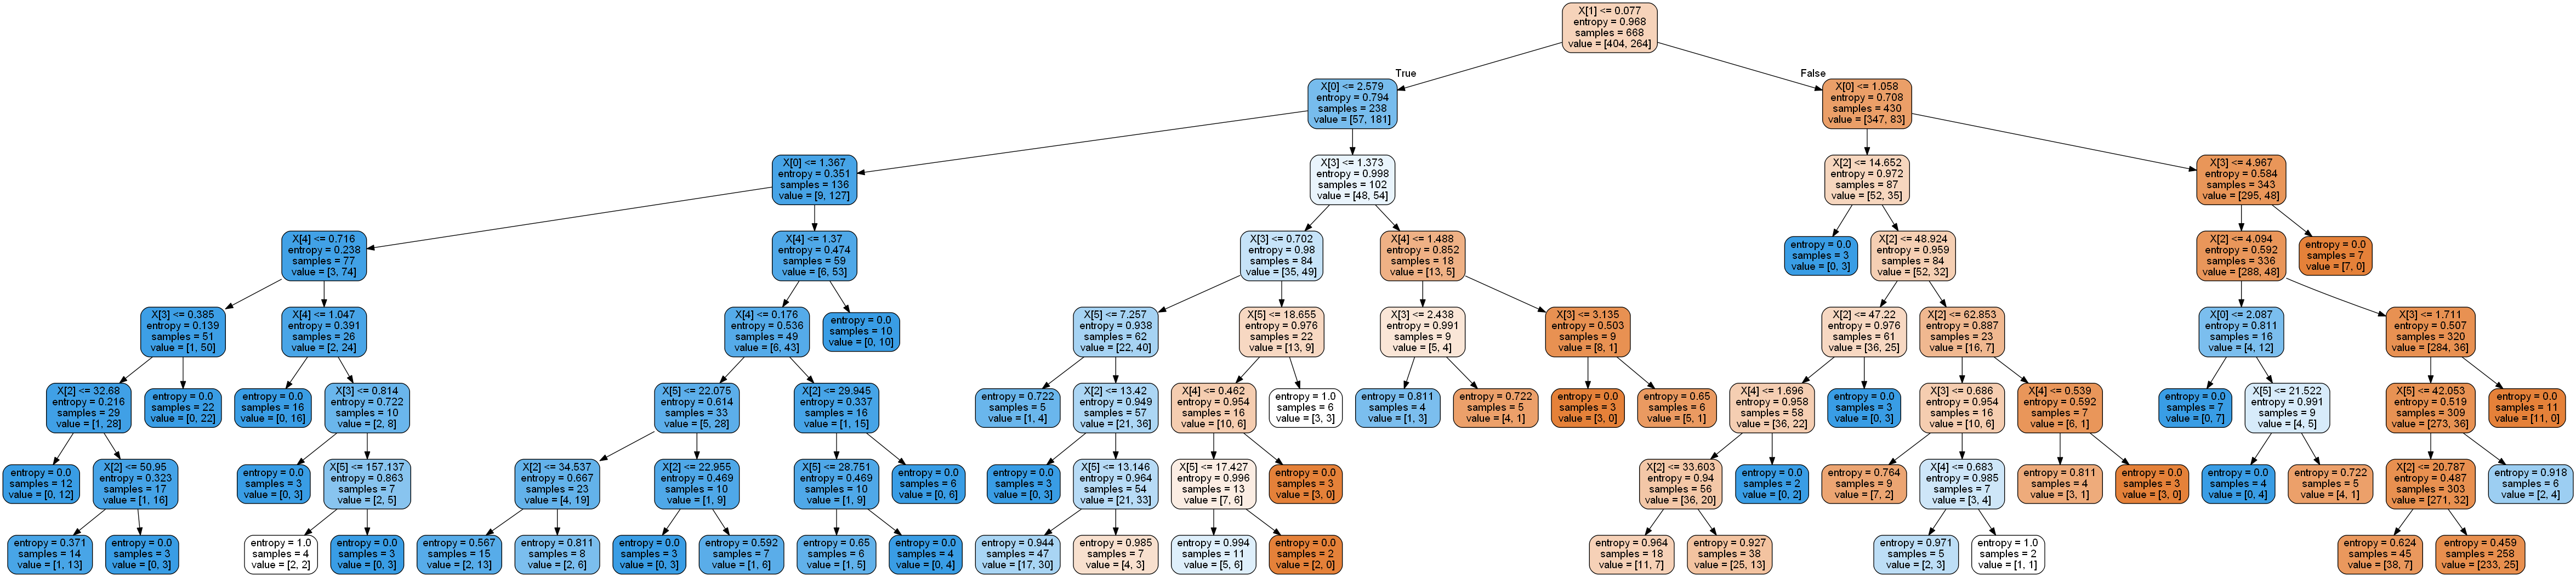

In [26]:
feature_name=list(X.columns)
class_name = list(y_train.unique())
# create a dot_file which stores the tree structure
dot_data = export_graphviz(clf,rounded = True,filled = True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
#graph.write_png("tree.png")
# Show graph
Image(graph.create_png())